# TASK 1

In [4]:
import cv2
from matplotlib import pyplot as plt
import sys
import os
import numpy as np
from tqdm import tqdm
from joblib import Parallel, delayed
from datetime import datetime


In [5]:
def image_loader(img_path):
    tmp_img_path_list = os.listdir(img_path)
    tmp_img_path_list.sort()
    start_img = tmp_img_path_list[-1]
    del tmp_img_path_list[-1]
    tmp_img_path_list.insert(0, start_img) # To make the start.jpg to be the first one in the array
    
    img_array_list = []
    for img in tmp_img_path_list:
        tmp_path = os.path.join(img_path, img)
        img_arr = cv2.imread(tmp_path)
        img_array_list.append(img_arr)
    return img_array_list

In [6]:
def weight_calc(inverse, size):
    if inverse==True:
        k = 2
    else :
        k = -2
    # Calculation
    ls_to_cvt = []
    for x in range(0, size): # x would be u or n
        for a in range(0, size): # a would be m or v
            tmp = np.exp((k * np.pi * (0 + 1.j) * a * x) / size)
            ls_to_cvt.append(tmp)
    arr_to_return = np.array(ls_to_cvt)
    arr_to_return = np.reshape(arr_to_return, (-1, size))
    
    # if inverse == True:
    #     arr_to_return = np.transpose(arr_to_return) 
    return arr_to_return

def weight_M(M, inverse):
    if inverse==False:
        weight_M = weight_calc(False, M)
    else :
        weight_M = weight_calc(True, M)
    return weight_M

def weight_N(N, inverse):
    if inverse==False:
        weight_N = weight_calc(False, N)
    else :
        weight_N = weight_calc(True, N)
    return weight_N

def fourier_Transform(img, patch_size, w_M, w_N, sRow, sCol, inverse):          # img for image input, patch_size for patch input, sRow for starting pixel in row level, sCol for starting pixel in col level, inverwse tfor whether you are up to inverse transform or not
    M, N = patch_size
    img = img[sRow : sRow + M, sCol : sCol + N]
    if inverse==False:
        return_map = (1 / (M * N)) * ((w_M @ img) @ w_N)
    else:
        return_map = (w_M @ img) @ w_N
    return return_map

# TASK 2

In [7]:
def phase_correlation(ref_map, to_compare, patch_size, w_M_inverse, w_N_inverse):
    before_inverse = np.multiply(ref_map, np.conj(to_compare)) / np.abs(np.multiply(ref_map, np.conj(to_compare)))
    M, N = patch_size
    after_inverse = fourier_Transform(before_inverse, patch_size, w_M_inverse, w_N_inverse, 0, 0, True)
    # phase_val = after_inverse[int(M/2), int(N/2)].real # SHOULD RECHECK FOR THE RETURN VALUE OF THE np.angle
    # print(phase_var)
    # phase_val = np.sum(np.abs(after_inverse[int(M/2) - 2 : int(M/2 + 3), int(N/2) - 2 : int(N/2) + 3]))
    # phase_val = np.abs(np.sum(after_inverse[int(M/2) - 1: int(M/2) + 1, int(N/2) - 1: int(N/2) + 1]))
    # phase_val = np.sum(np.abs(after_inverse))
    phase_val = np.max(after_inverse.real)
    return phase_val

In [8]:
def get_activation(img, reference_patch_ftmap, patch_size, w_M, w_N, w_M_inverse, w_N_inverse):
    act_tmp = []
    M, N = patch_size
    for i in tqdm(range(0, 360 - M, 1)):
        for j in range(0, 480 - N, 1):
            temp_patch = img[i:i+M, j:j+N]
            temp_patch = fourier_Transform(temp_patch, patch_size, w_M, w_N, sRow=0, sCol=0, inverse=False)
            corel_val = phase_correlation(temp_patch, reference_patch_ftmap, patch_size, w_M_inverse, w_N_inverse)
            act_tmp.append(corel_val)
    return np.reshape(act_tmp, (-1, 480 - N))

In [9]:
def normalize_activation(img):
    abs_patch = np.abs(img)
    color_activation = (abs_patch - np.min(abs_patch)) / (np.max(abs_patch) - np.min(abs_patch))
    patch_activation = (255 * color_activation).astype(int)
    return patch_activation

In [15]:
def main():
    img_path = '/home/carpedkm/GitHub/Signals_and_Systems/dataset (1)/'
    save_dir = '/home/carpedkm/GitHub/Signals_and_Systems/result_activation'
    patch_size = (26, 30)
    M, N = patch_size
    img_list = image_loader(img_path)
    print('[IMAGE LOAD COMPLETE]')
    w_M = weight_M(M, False)
    w_N = weight_N(N, False)

    w_M_inverse = weight_M(M, True)
    w_N_inverse = weight_N(N, True)
    # print(img_list[0][137:167, 270:300])
    # plt.imshow(img_list[0][138:162, 276:294])
    # plt.show()
    b_ref, g_ref, r_ref = cv2.split(img_list[0])
    b_ref_mir, g_ref_mir, r_ref_mir = cv2.split(cv2.flip(img_list[0], 1)) # horizontal lip

    sRow = 136
    sCol = 275
    sRow_f = 139
    sCol_f = 178
    b_ref = fourier_Transform(b_ref, patch_size, w_M, w_N, sRow, sCol, inverse=False)
    g_ref = fourier_Transform(g_ref, patch_size, w_M, w_N, sRow, sCol, inverse=False)
    r_ref = fourier_Transform(r_ref, patch_size, w_M, w_N, sRow, sCol, inverse=False)
    b_ref_mir = fourier_Transform(b_ref_mir, patch_size, w_M, w_N, sRow_f, sCol_f, inverse=False)
    g_ref_mir = fourier_Transform(g_ref_mir, patch_size, w_M, w_N, sRow_f, sCol_f, inverse=False)
    r_ref_mir = fourier_Transform(r_ref_mir, patch_size, w_M, w_N, sRow_f, sCol_f, inverse=False)
    b_ref = (b_ref + b_ref_mir) / 2
    g_ref = (g_ref + g_ref_mir) / 2
    r_ref = (r_ref + r_ref_mir) / 2

    # inverse_of_ref_ftmap = fourier_Transform(reference_patch_ftmap, patch_size, w_M_inverse, w_N_inverse, sRow=0, sCol=0, inverse=True)
    print('[PHASE CORREL CALC start]')
    # temp_patch = img_list[0][0:M, 0:N]
    # corel_val = phase_correlation(temp_patch, reference_patch_ftmap, patch_size, w_M_inverse, w_N_inverse)
    # print(corel_val[1, 1])
    now = datetime.now()
    date_time = now.strftime("%m/%d/%Y, %H:%M:%S")
    save_dir = save_dir + '_' + str(patch_size[0]) + '_' + str(patch_size[1]) + '_' + date_time
    os.makedirs(save_dir, exist_ok=True)

     # Reference patch imshow
    # temp_patch_rf = (reference_patch_ftmap  - np.min(reference_patch_ftmap )) / (np.max(reference_patch_ftmap ) - np.min(reference_patch_ftmap ))
    # temp_patch_rf = (255 * temp_patch_rf).astype(int)
    # temp_patch_rf[0, 0] = 0
    # plt.imshow(temp_patch_rf)
    # plt.show()

    # return

    for cnt, img in enumerate(img_list):
        # kernel = np.ones((5, 5), np.float32)/ 25
        # img = cv2.filter2D(img, -1, kernel)
        # img = cv2.equalizeHist(img)
        print('IMAGE', cnt, 'START')
        max_corel_val = 0
        r_temp = 0
        c_temp = 0
        # cv2.imshow('img', img)
        # cv2.waitKey(0)
        padding = (int(M/2), int(N/2))
        b_img, g_img, r_img = cv2.split(img)
        # mean_of_img = np.sum(img) / (img.shape[0] * img.shape[1])
        # img = np.pad(img, ((padding[0], padding[0]), (padding[1], padding[1]), 'constant', constant_values=mean_of_img)
        # img[img > 110] = 0
        # img[img < 80] = 0
        
        b_activation = get_activation(b_img, b_ref, patch_size, w_M, w_N, w_M_inverse, w_N_inverse)
        g_activation = get_activation(g_img, g_ref, patch_size, w_M, w_N, w_M_inverse, w_N_inverse)
        r_activation = get_activation(r_img, r_ref, patch_size, w_M, w_N, w_M_inverse, w_N_inverse)
        # b_activation_show = normalize_activation(b_activation)
        # g_activation_show = normalize_activation(g_activation)
        # r_activation_show = normalize_activation(r_activation)
        # plt.imshow(b_activation_show)
        # plt.show()
        # plt.imshow(g_activation_show)
        # plt.show()
        # plt.imshow(r_activation_show)
        # plt.show()
        # cv2.imshow('b', np.array(b_activation_show))
        # cv2.waitKey(0)
        # cv2.imshow('b', np.array(g_activation_show))
        # cv2.waitKey(0)
        # cv2.imshow('r', np.array(r_activation_show))
        # cv2.waitKey(0)

        activation_map = (0.3 * b_activation + 0.3 * g_activation + 0.4 * r_activation)
        # activation_map = activation_map.real
        activation_map = r_activation

        max_corel_val = 0
        for i in range(0, 360 - M):
            for j in range(0, 480 - N):
                if max_corel_val < activation_map[i, j]:
                    max_corel_val = activation_map[i, j]
                    r_temp = i
                    c_temp = j
                
        tmp = cv2.rectangle(img, (c_temp, r_temp), (c_temp + N, r_temp + M), (255, 255, 255), 3)
        plt.imshow(tmp)
        plt.show()
        # ACTIVATION MAP
        act_tmp = np.array(activation_map)
        activation_map_tmp = 'activation_' + str(cnt) + '.jpg'
        annotated_temp = 'result_' + str(cnt) + '.jpg'
        

        to_save_activation = os.path.join(save_dir, activation_map_tmp)
        to_save_annotation = os.path.join(save_dir, annotated_temp)
        
        # ACTIVATION TO SAVE : normalizing
        abs_patch = np.abs(act_tmp)
        patch_activation = (abs_patch - np.min(abs_patch)) / (np.max(abs_patch) - np.min(abs_patch))
        patch_activation = (255 * patch_activation).astype(int)

        # plt.imshow(patch_activation)
        # plt.show()
             
        # act_tmp = cv2.normalize(abs_patch, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        cv2.imwrite(to_save_activation, patch_activation)

         # ANNOTATION TO SAVE
        cv2.imwrite(to_save_annotation, tmp)

  1%|          | 3/334 [00:00<00:11, 28.74it/s][IMAGE LOAD COMPLETE]
[PHASE CORREL CALC start]
IMAGE 0 START
100%|██████████| 334/334 [00:11<00:00, 30.19it/s]


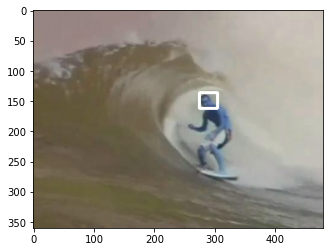

100%|██████████| 334/334 [00:10<00:00, 30.78it/s]


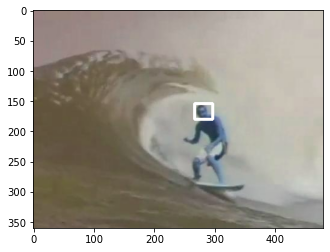

100%|██████████| 334/334 [00:11<00:00, 29.54it/s]


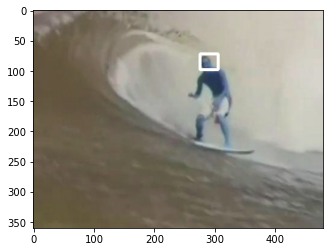

100%|██████████| 334/334 [00:11<00:00, 29.53it/s]


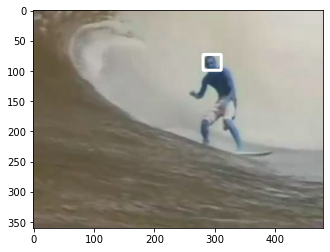

100%|██████████| 334/334 [00:11<00:00, 29.97it/s]


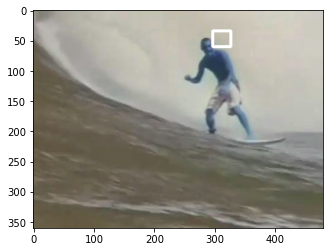

100%|██████████| 334/334 [00:11<00:00, 29.66it/s]


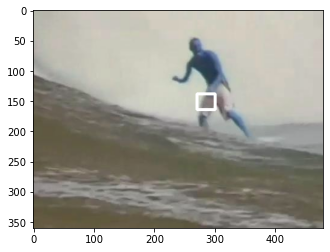

100%|██████████| 334/334 [00:11<00:00, 29.28it/s]


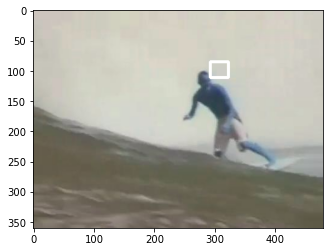

100%|██████████| 334/334 [00:10<00:00, 30.46it/s]


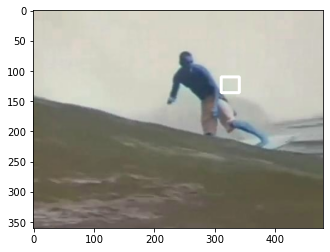

100%|██████████| 334/334 [00:11<00:00, 28.45it/s]


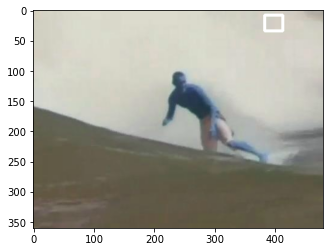

100%|██████████| 334/334 [00:11<00:00, 28.13it/s]


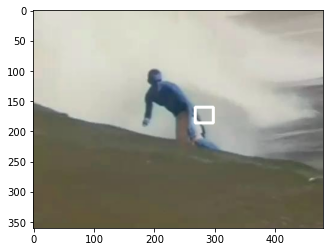

100%|██████████| 334/334 [00:11<00:00, 28.36it/s]


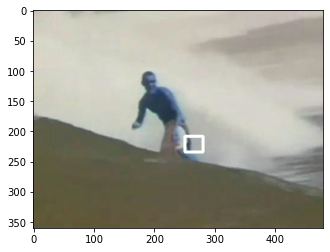

In [16]:
main()